In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
! export PYTHONPATH=/Users/ilariasartori/Documents/GitHub/bnn-uncertainty/markovalexander/DVI-master

In [3]:
# model1.state_dict()['l'+str(i)+'.weight_rho'].data.copy_(rho * signalRatio - (1-signalRatio)*20) 

# #preserves rho when signalRatio is 1, but sets it equal to -20 when it's 0


In [4]:
def getThreshold(model,buckets):
    sigmas = []
    mus = []

    sigmas.append(model.state_dict()['fc1.W_logvar'].view(-1).cpu().detach().numpy())
    sigmas.append(model.state_dict()['fc2.W_logvar'].view(-1).cpu().detach().numpy())
    sigmas.append(model.state_dict()['fc3.W_logvar'].view(-1).cpu().detach().numpy())

    mus.append(model.state_dict()['fc1.W'].view(-1).cpu().detach().numpy())
    mus.append(model.state_dict()['fc2.W'].view(-1).cpu().detach().numpy())
    mus.append(model.state_dict()['fc3.W'].view(-1).cpu().detach().numpy())
    

    sigmas = np.concatenate(sigmas).ravel()
    mus = np.concatenate(mus).ravel()
    
#     sigmas = np.log(1. + np.exp(sigmas))
    sigmas = np.sqrt(np.exp(sigmas))
    
    sign_to_noise = np.abs(mus) / sigmas
    p = np.percentile(sign_to_noise, buckets)
    
    s = np.log10(sign_to_noise)/10
    hist, bin_edges = np.histogram(s, bins='auto')
    hist = hist / s.size
    X =[]
    for i in range(hist.size):
        X.append((bin_edges[i]+bin_edges[i+1])*0.5)
    
    plt.plot(X,hist)
    plt.axvline(x= np.log10(p[4])/10, color='red')
    plt.ylabel('Density')
    plt.xlabel('Signal−to−Noise Ratio (dB)')
    plt.savefig('ResultsPruning/SignalToNoiseRatioDensity_FC_variance.png')
    plt.savefig('ResultsPruning/SignalToNoiseRatioDensity_FC_variance.eps', format='eps', dpi=1000)

    plt.figure(2)
    Y = np.cumsum(hist)
    plt.plot(X, Y)
    plt.axvline(x= np.log10(p[4])/10, color='red')
    plt.hlines(y= 0.75, xmin=np.min(s),xmax=np.max(s),colors='red')
    plt.ylabel('CDF')
    plt.xlabel('Signal−to−Noise Ratio (dB)')
    plt.savefig('ResultsPruning/SignalToNoiseRatioDensity_FC_variance_CDF.png')
    plt.savefig('ResultsPruning/SignalToNoiseRatioDensity_FC_variance_CDF.eps', format='eps', dpi=1000)
#     plt.savefig('./Results/SignalToNoiseRatioDensity_CDF_BBB_mnist_1200_0.0001_ID0_notebook_epoch_299.png')
#     plt.savefig('./Results/SignalToNoiseRatioDensity_CDF_BBB_mnist_1200_0.0001_ID0_notebook_epoch_299.eps', format='eps', dpi=1000)
    
    return p

### Load model

In [5]:
PATH = './Checkpoints/Fc_variance_epoch_30.pth'
# model = LinearVariance(args).to(args.device)

checkpoint = torch.load(PATH)

args = type('', (), {})()
args.var1 = None
args.var2 = None
args.var3 = None
args.var2 = None
args.mcvi = False

from core.models import LinearVariance
model = LinearVariance(args=args)
# model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(checkpoint)




<All keys matched successfully>

### Get thresholds 

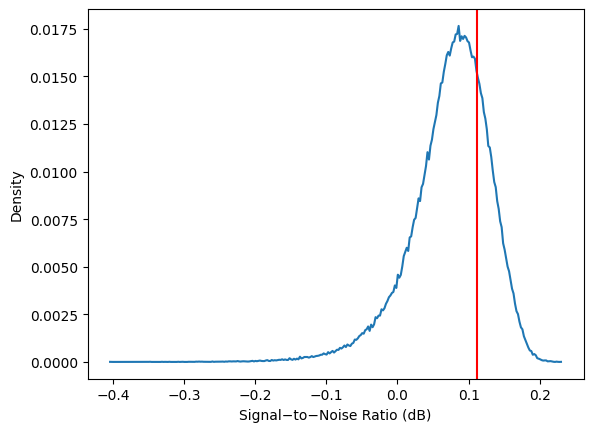

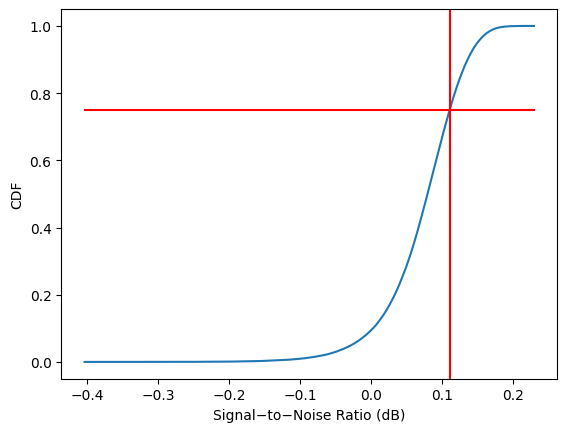

In [6]:
buckets = np.asarray([0,10,25,50,75,80, 85,90, 95, 98, 99, 99.9])
thresholds = getThreshold(model,buckets)

### Prune

In [7]:
import copy
from torch.autograd import Variable

# start_path = '/content/drive/MyDrive/MLMI4 Advanced ML/John_Pruning_Tests/Early Testing/mnist_1200_sgd_constant_xavier_epoch_99.pth'
model_name = 'FC-Variance'
# model = BayesianNetwork()
# model.load_state_dict(torch.load(start_path, map_location='cpu'))

for index in range(buckets.size):
    print(buckets[index],'-->',thresholds[index])
    t = Variable(torch.Tensor([thresholds[index]]))
    model1 = copy.deepcopy(model)
    for i in range(1, 4):
        logvar = model.state_dict()['fc'+str(i)+'.W_logvar']  # Is this like rho?
        mu = model.state_dict()['fc'+str(i)+'.W'] 
        
#         sigma = np.log(1. + np.exp(rho.cpu().numpy()))
        sigma = np.sqrt(np.exp(logvar.cpu().numpy()))
        
        
        signalRatio = np.abs(mu.cpu().numpy()) / np.abs(sigma)
        signalRatio = (torch.from_numpy(signalRatio) > t).float() * 1
#         model1.state_dict()['fc'+str(i)+'.W_logvar'].data.copy_(logvar * signalRatio) 
        model1.state_dict()['fc'+str(i)+'.W_logvar'].data.copy_(logvar * signalRatio - (1-signalRatio)*20) 
                                #sets rho to -20, which is ~0 ONLY if signalRatio = 0. Otherwise doesn't change rho
        model1.state_dict()['fc'+str(i)+'.W'].data.copy_(mu * signalRatio)

    torch.save(model1.state_dict(), 
               'ResultsPruning/' + model_name + 'Pruned'+str(buckets[index])+'.pth')
    
    
    

0.0 --> 8.889366290532053e-05
10.0 --> 1.0922345042228698
25.0 --> 2.80143940448761
50.0 --> 6.414016485214233
75.0 --> 13.15409255027771
80.0 --> 15.531110572814947
85.0 --> 18.738285064697266
90.0 --> 23.540538024902347
95.0 --> 32.36632041931152
98.0 --> 44.75637107849108
99.0 --> 54.535555267334
99.9 --> 89.80793360138078


In [ ]:
from time import time

def evaluate_model(model, test_loader, args):
    model.eval()
    t_dvi = time()
    test_acc_dvi = evaluate(model, test_loader, mode='dvi', args=args)
    t_dvi = time() - t_dvi

#     if not args.no_mc:
#         t_mc = time()
#         test_acc_mcvi = evaluate(model, test_loader, mode='mcvi', args=args)
#         t_mc = time() - t_mc
#         logger.add(epoch, te_acc_mcvi=test_acc_mcvi, te_time_mcvi=t_mc)

#     test_acc_samples = evaluate(model, test_loader, mode='samples_dvi',
#                                 args=args)
#     logger.add(epoch, te_acc_dvi=test_acc_dvi,
#                te_acc_samples=test_acc_samples, te_time_dvi=t_dvi)
    return test_acc_dvi

In [ ]:
from core.utils import load_mnist, one_hot_encoding, evaluate, pred2acc

args.batch_size = 32 
args.test_batch_size = 32

train_loader, test_loader = load_mnist(args)

args.data_size = len(train_loader.dataset)
args.use_samples = False
args.device = 'cpu'
args.reshape = True

# evaluate_model(model, test_loader, args)

In [ ]:
checkpoint = torch.load(PATH)
model = LinearVariance(args=args)
model.load_state_dict(checkpoint)
original_accuracy = evaluate_model(model, test_loader, args)
original_accuracy


In [ ]:
pruned_accuracies = {}
for index in range(buckets.size):
    # Load model
    path = 'ResultsPruning/' + model_name + 'Pruned' + str(buckets[index]) +'.pth'
    checkpoint = torch.load(path)
    model = LinearVariance(args=args)
    model.load_state_dict(checkpoint)
    pruned_accuracies[buckets[index]] = evaluate_model(model, test_loader, args)
pruned_accuracies